In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

### Load Data

Data from csv file is cleaned beforehand

In [2]:
datapath = 'data/modified/'
csv_file_nonet = datapath + 'C1W1 and C1W2 NonNetwork Data.csv'
csv_file_net = datapath + 'C1W1 C1W2 With Network No NickInit.csv'

df_nonet = pd.read_csv(csv_file_nonet)
df_net = pd.read_csv(csv_file_net)

In [3]:
fields = list(df_net.columns)
C1W1nonet_idx, C1W1nonet_vars = [], []
C1W2nonet_idx, C1W2nonet_vars = [], []
C1W1net_idx, C1W1net_vars = [], []

for field in fields:
    if field[5:7] != 'NS' and field[5:8] != 'NDX' and field[5:] != 'ND1':  # non-network
        if field[0:4] == 'C1W1':
            if field[5:] == 'ND1.1':  # there are 2 variables of same name 'C1W1_ND1', this is non-network one
                C1W1nonet_vars.append('ND1')
            else:
                C1W1nonet_vars.append(field[5:])
            C1W1nonet_idx.append(fields.index(field))
        elif field[0:4] == 'C1W2':
            C1W2nonet_vars.append(field[5:])
            C1W2nonet_idx.append(fields.index(field))
    else:
        if field[0:4] == 'C1W1':
            C1W1net_vars.append(field[5:])
            C1W1net_idx.append(fields.index(field))

df_C1W1nonet = df_net.iloc[:,C1W1nonet_idx]
df_C1W2nonet = df_net.iloc[:,C1W2nonet_idx]
df_C1W1net = df_net.iloc[:,C1W1net_idx]

# Remove prefixes from column names
df_C1W1nonet.columns = C1W1nonet_vars
df_C1W2nonet.columns = C1W2nonet_vars
df_C1W1net.columns = C1W1net_vars

In [4]:
# df_C1W1nonet.to_csv('C1W1_nonnetwork.csv', index=False)
# df_C1W2nonet.to_csv('C1W2_nonnetwork.csv', index=False)

In [5]:
len(list(df_C1W1nonet.columns))

199

### Create Mappings of Variables Across Two Waves

In [6]:
f1 = datapath + "C1W1_nonnetwork.txt"  # wave 1, non-network
f2 = datapath + "C1W2_nonnetwork.txt"  # wave 2, non-network
f3 = datapath + "C1W1_network.txt"  # wave 1, network

varnames1, descrs1 = [], []
with open(f1, 'r') as file:  # read from C1W1
    while (line := file.readline().rstrip()):  # go over each line
        chars = line.split()
        varnames1.append(chars[0])
        descrs1.append(' '.join(chars[1:]))

dict1 = {re.sub('[^A-Za-z0-9]+$', '', varnames1[i]): descrs1[i] for i in range(len(varnames1))}

In [7]:
varnames2, descrs2 = [], []
mappings = {}  # mappings of non-network variables between C1W1 and C1W2
with open(f2, 'r') as file:  # read from C1W2
    i = 0  # keep track of column index of C1W2 vars i.e., line number in f2
    while (line := file.readline().rstrip()):  # go over each line
        chars = line.split()
        varnames2.append(chars[0])
        descr = ' '.join(chars[1:])
        descrs2.append(descr)        
        if descr in descrs1:
            mappings[varnames1[descrs1.index(descr)]] = (chars[0], descr, descrs1.index(descr), i)
        i += 1

dict2 = {re.sub('[^A-Za-z0-9]+$', '', varnames2[i]): descrs2[i] for i in range(len(varnames2))}

'mappings' dict: Each key is the variable name in wave 1, each corresponding value is a 4-tuple, where the first element is the variable name in wave 2, followed by the description as the second element, and the last 2 elements are pair of column indices  in wave 1 and 2's dataframes, respectively.

In [8]:
import json

with open('mappings.json', 'w') as f:
    json.dump(mappings, f)

In [9]:
# val = mappings['TB3*']
# a = df_C1W1nonet.iloc[:,val[2]]
# b = df_C1W2nonet.iloc[:,val[3]]
# for j in range(len(df_C1W1nonet.index)):
#     print(f'{a[j]}, {type(a[j])}, {b[j]}, {type(b[j])}')

In [10]:
def plot_hist(key):
    val = mappings[key]
    fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
    plt.suptitle(key)
    axs[0].hist(df_C1W1nonet.iloc[:,val[2]],bins=20)
    axs[1].hist(df_C1W2nonet.iloc[:,val[3]],bins=20)

### Visualization
Histograms of variables available in both waves (note that total participants are 35, some variables have missing data i.e., NaN)

Some corner cases:
- Q36 is combination of AL6A (for men) and AL6B (for women)  --> merge into one AL6 for simplicity
- DA5-8 <=> Q100-105 (patterns of using alcohol and drugs). W1 has more detailed info on using which drug(s) at specifically which time of the day. In particular, DA7a-d and DA8a-d (drug(s) generally use during morning/afternoon/evening/night on an average weekday/weekend) are supersets of Q103 and Q105 (whether generally use [some drug] on an average weekday/weekend), respectively.

/tmp/ipykernel_2115/1703113092.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)


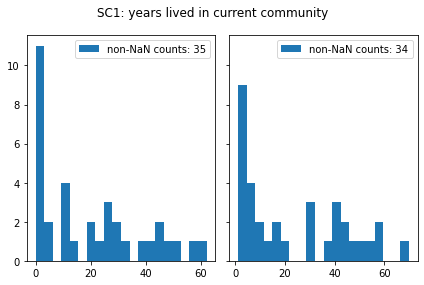

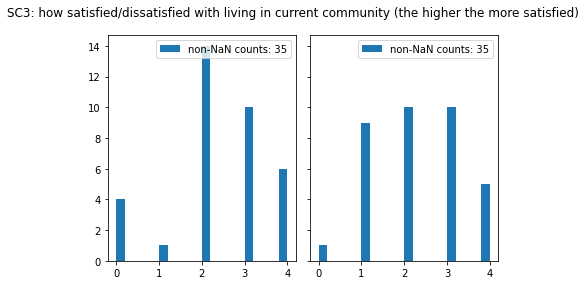

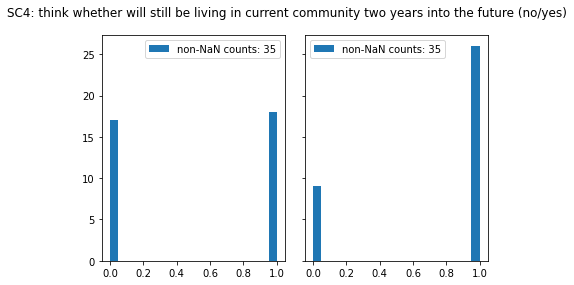

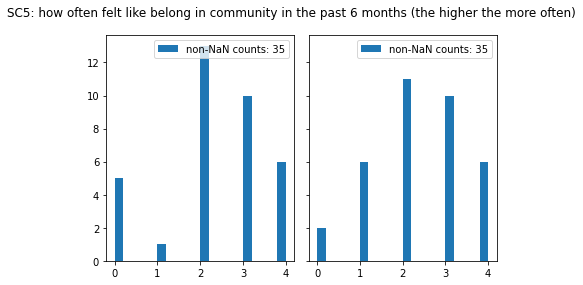

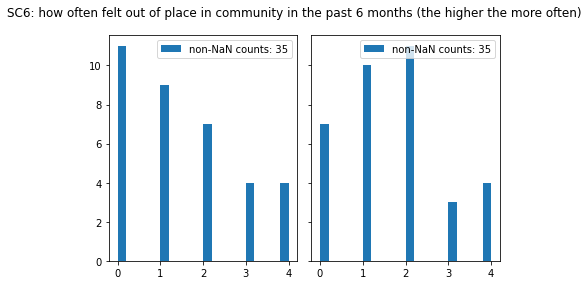

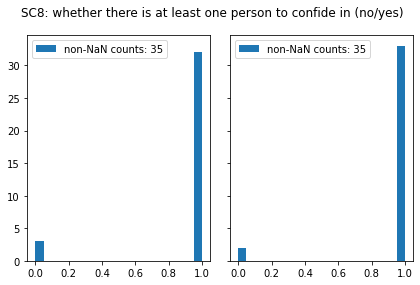

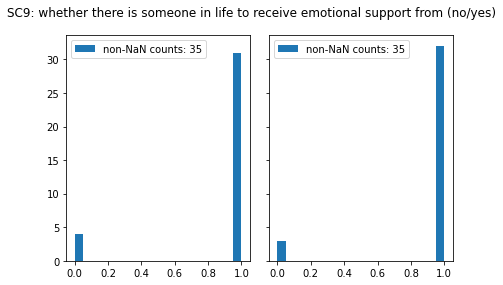

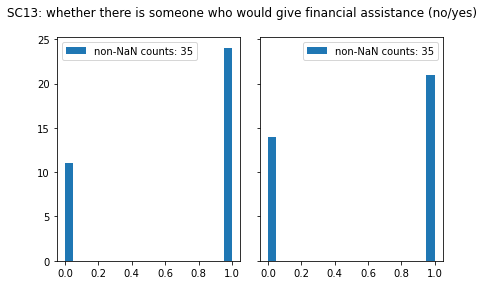

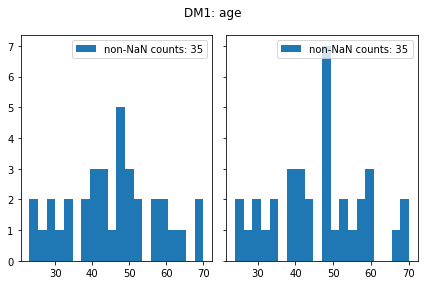

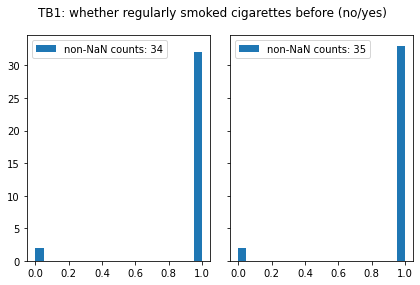

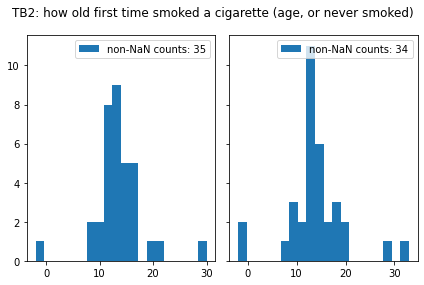

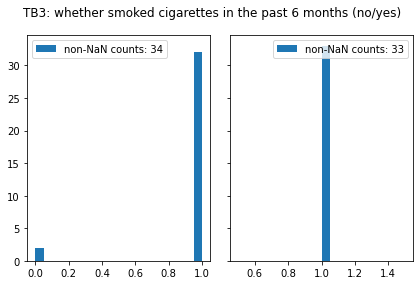

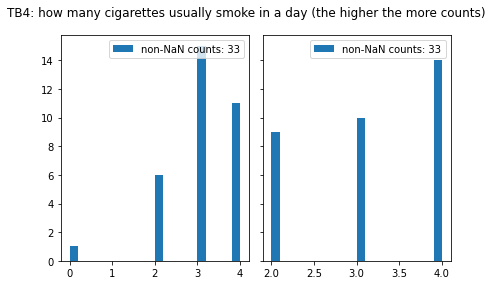

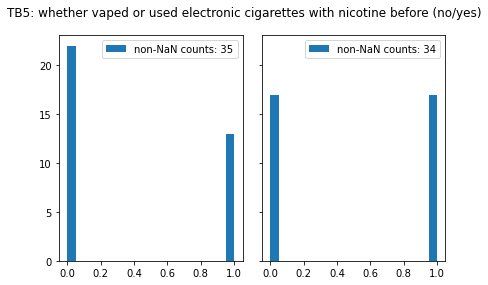

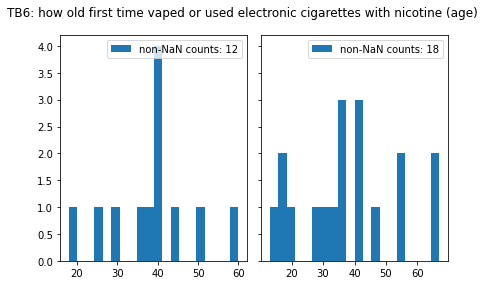

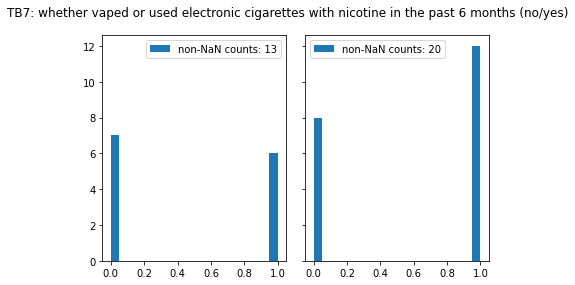

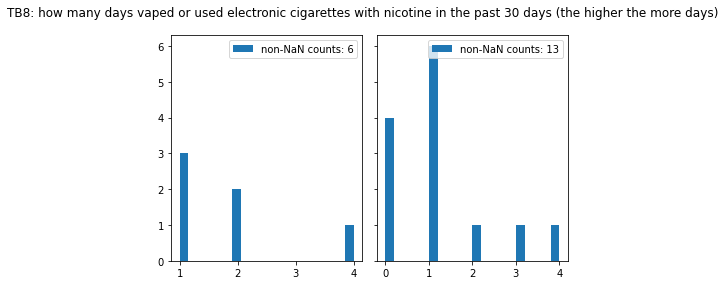

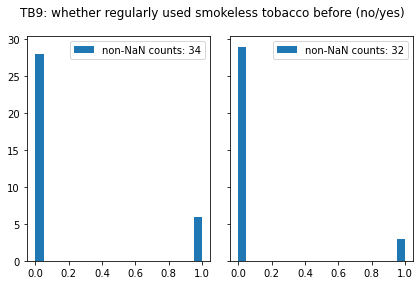

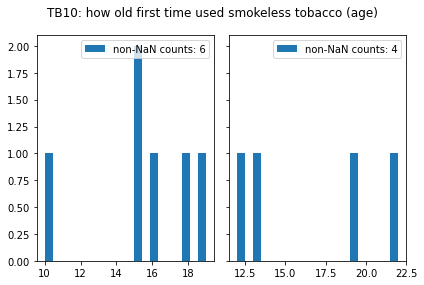

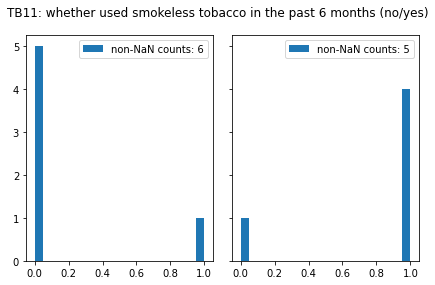

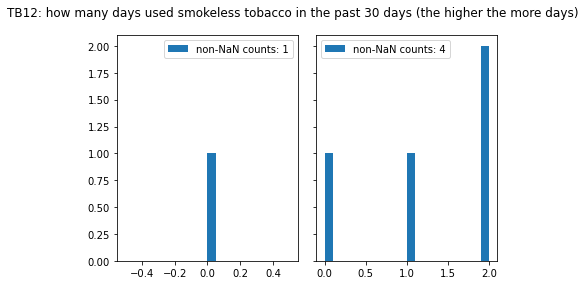

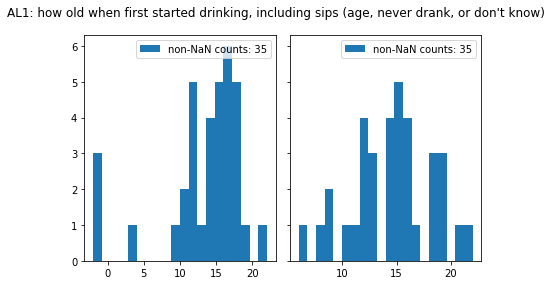

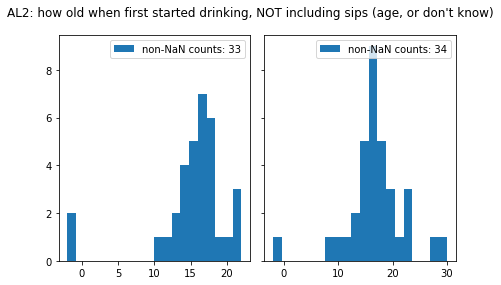

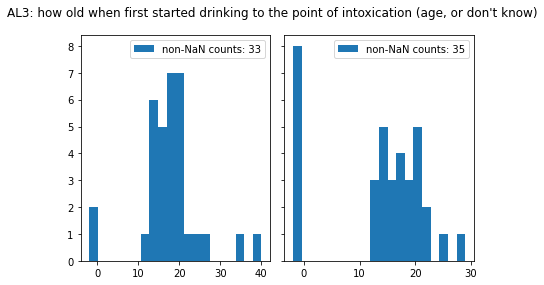

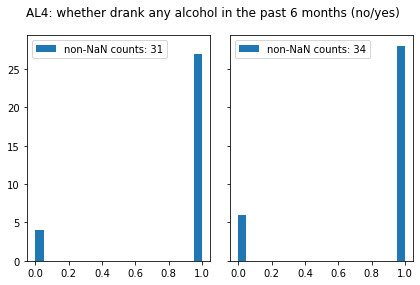

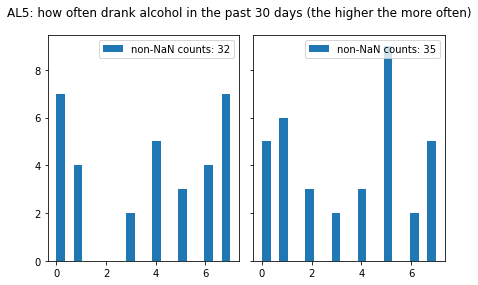

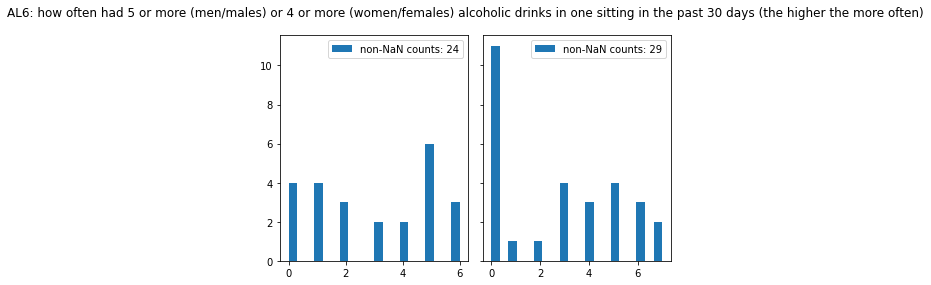

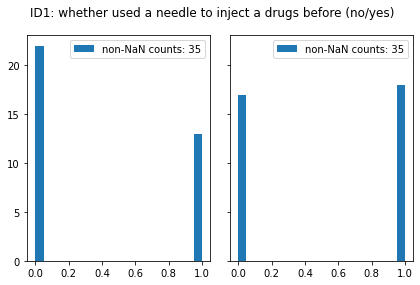

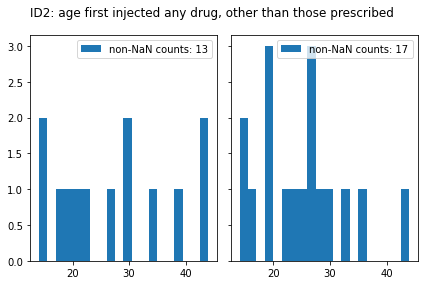

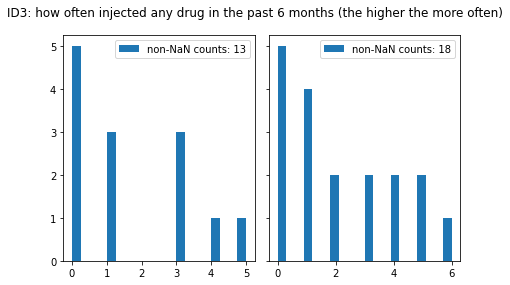

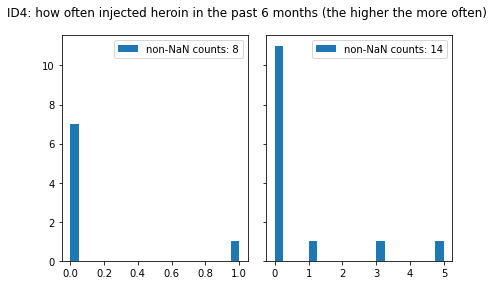

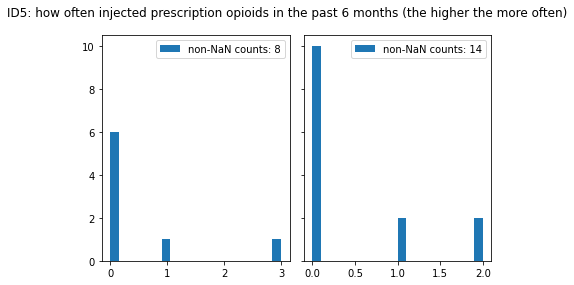

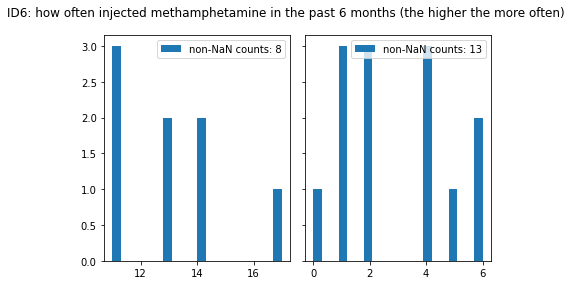

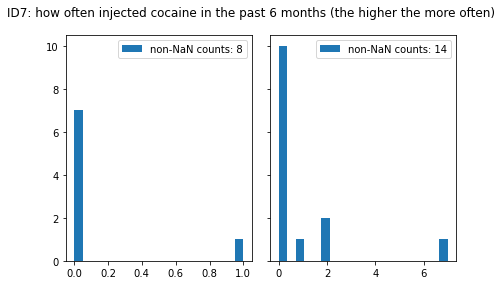

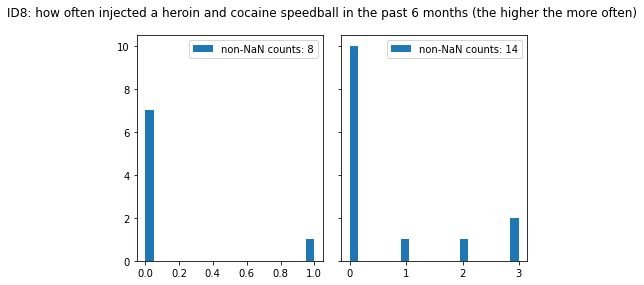

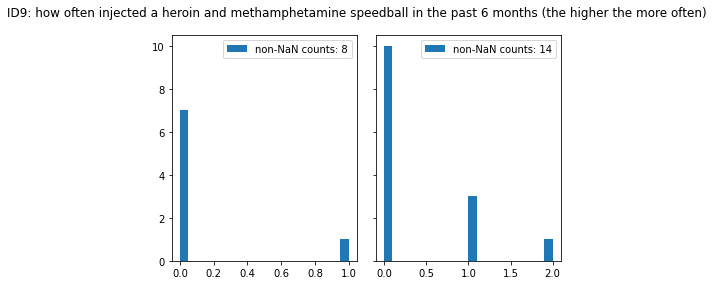

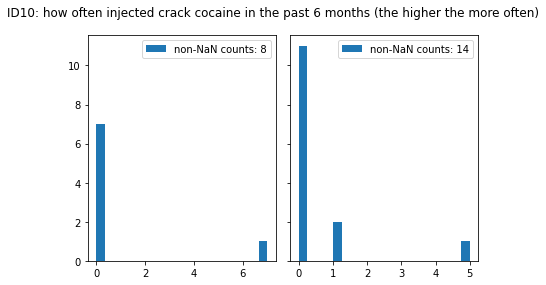

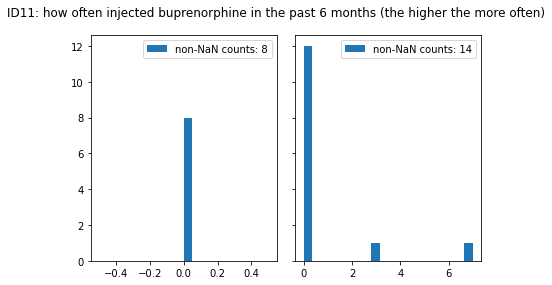

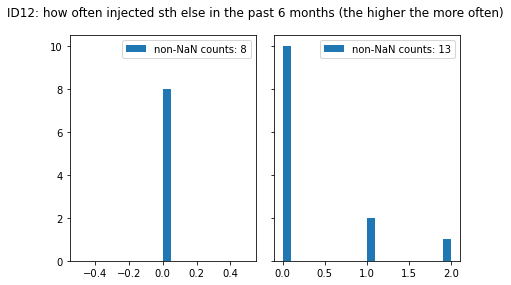

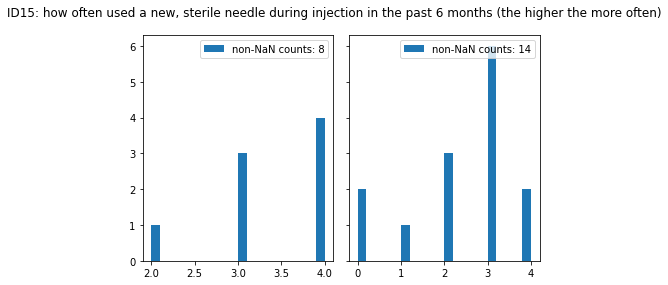

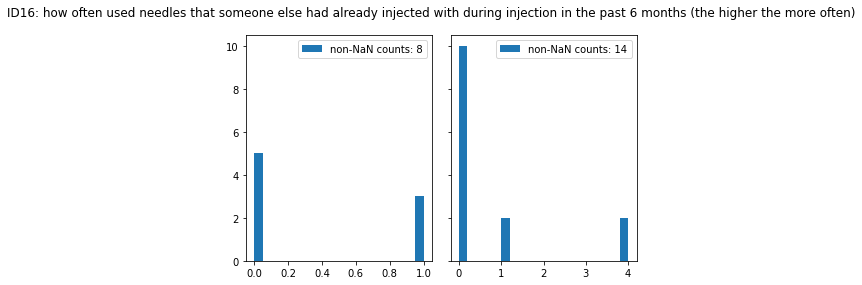

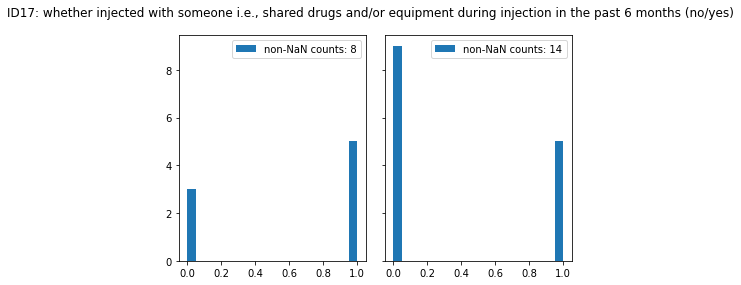

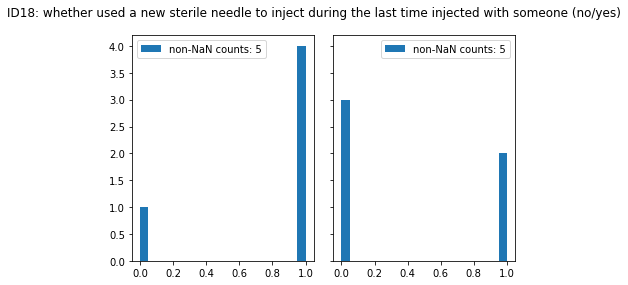

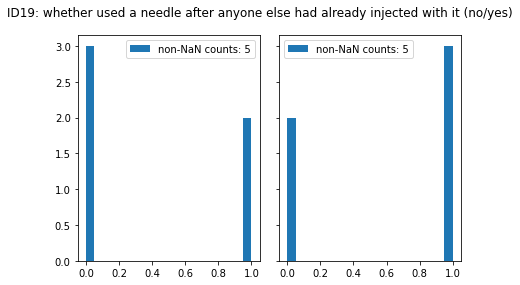

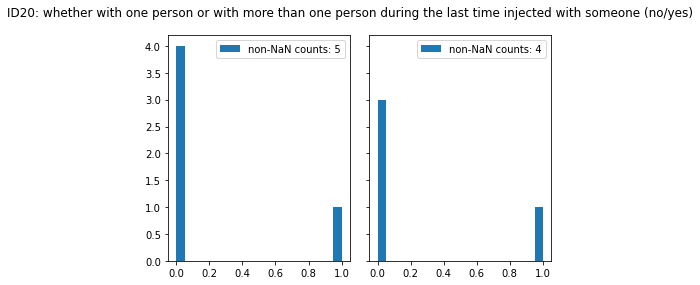

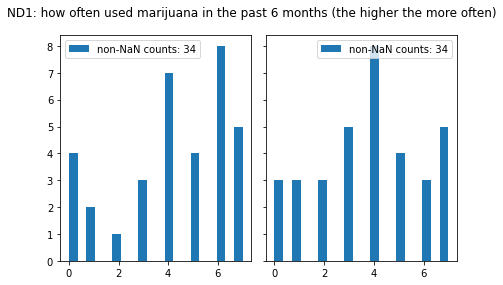

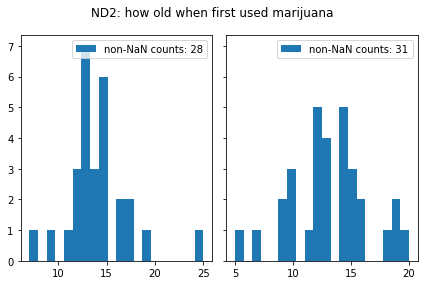

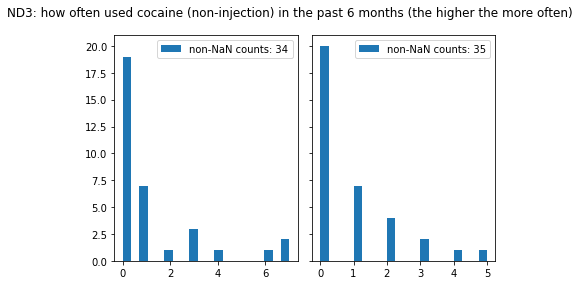

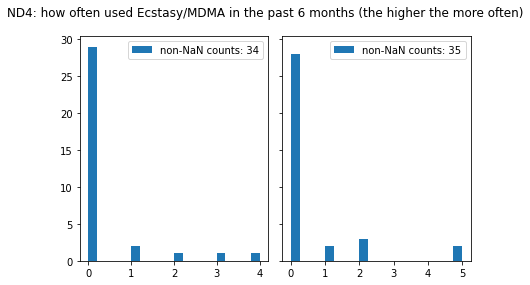

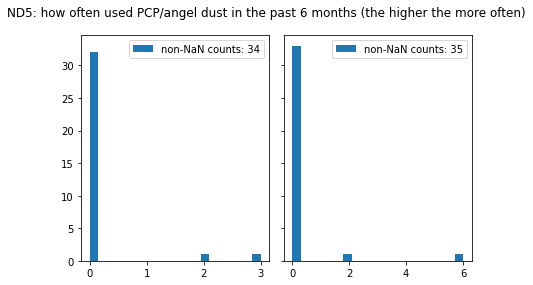

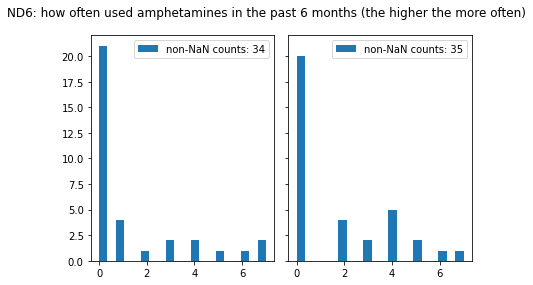

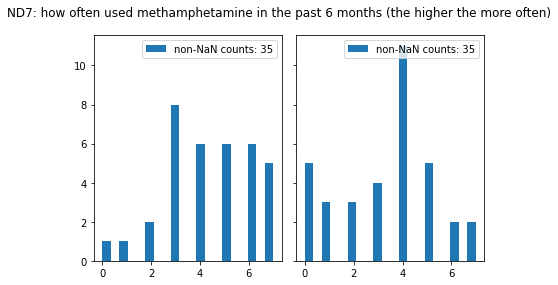

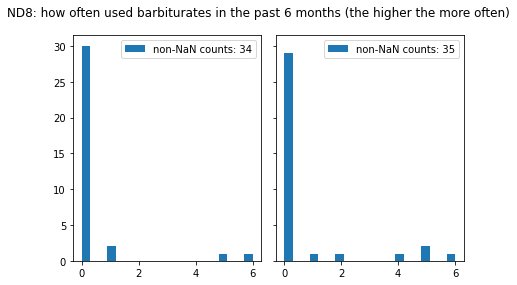

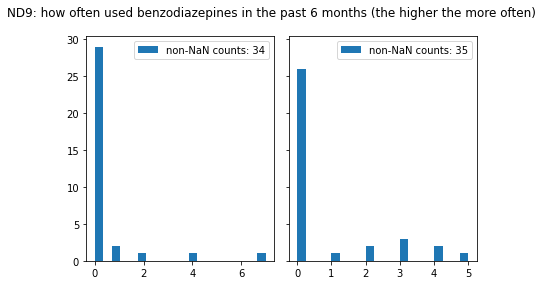

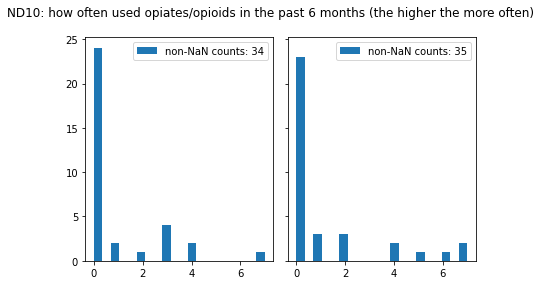

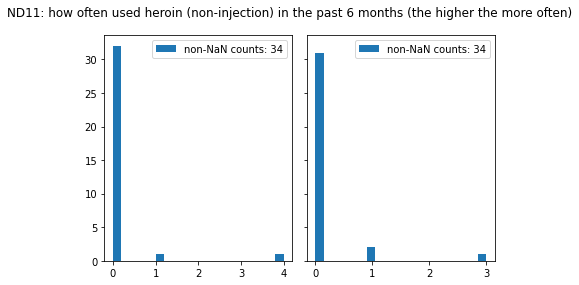

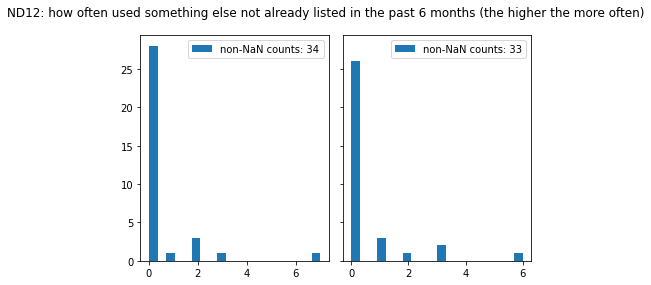

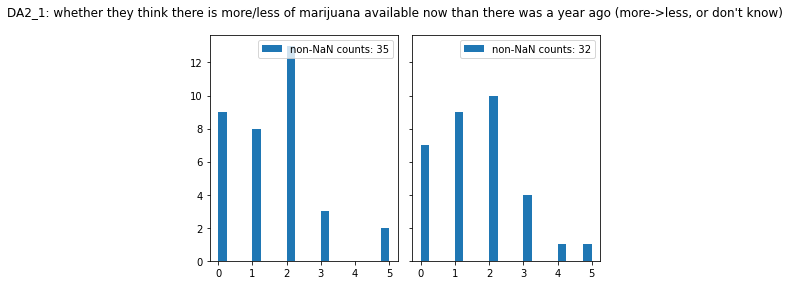

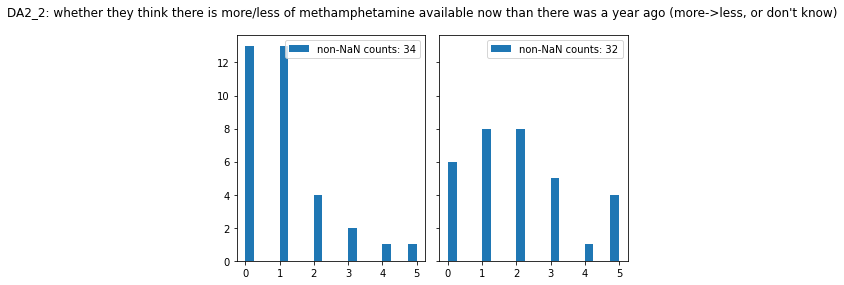

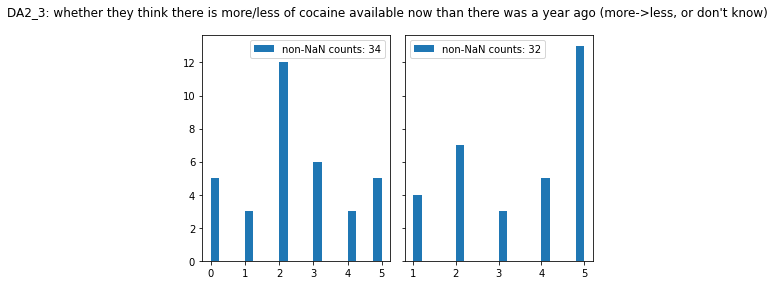

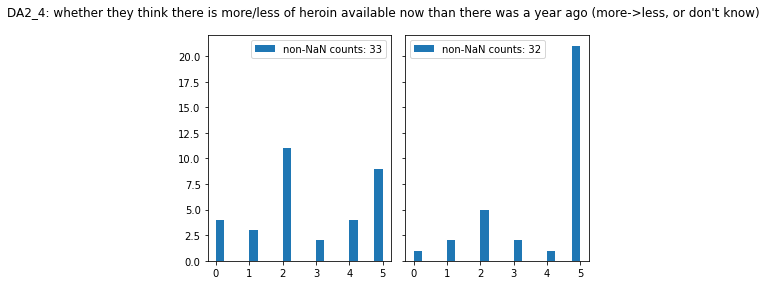

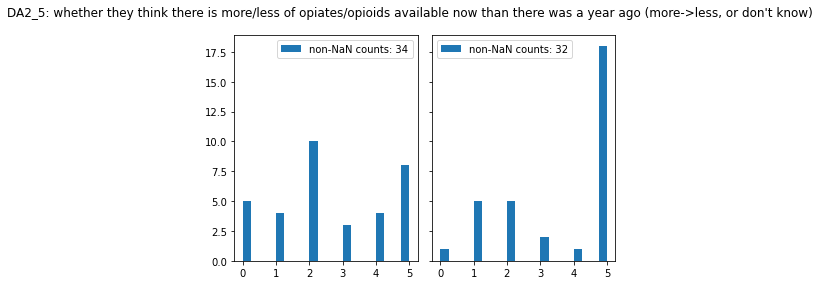

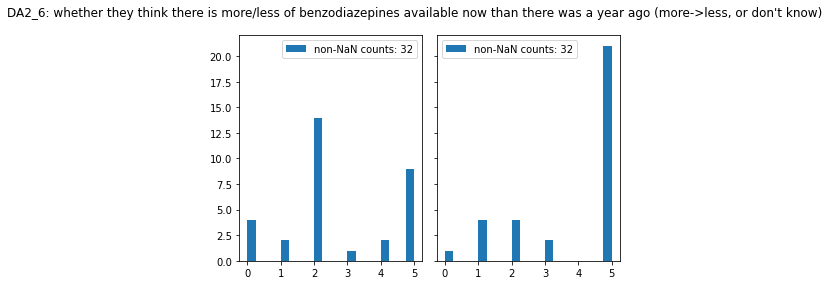

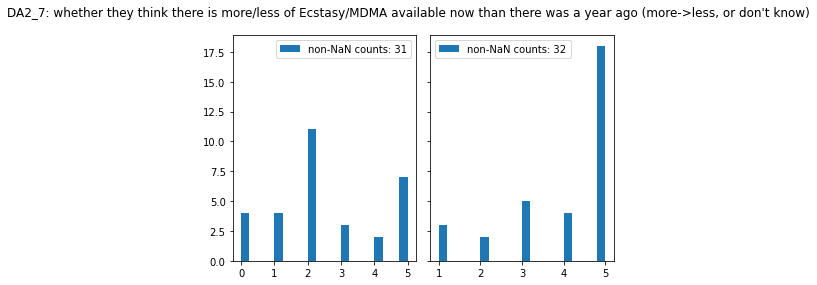

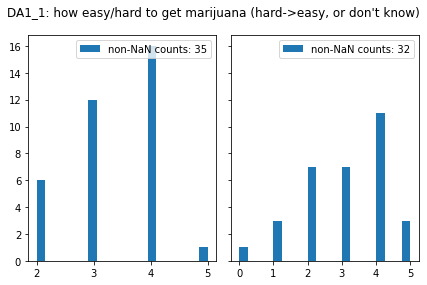

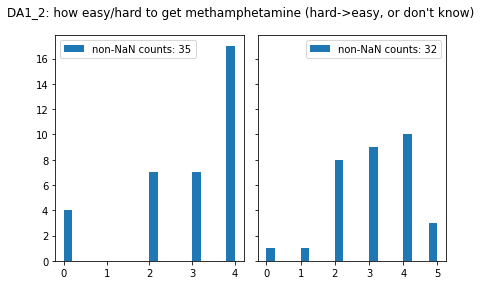

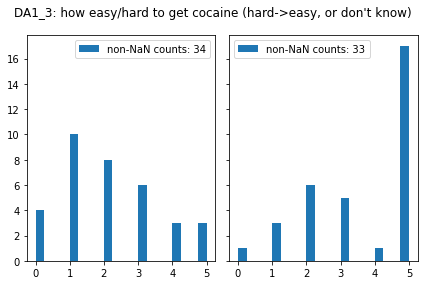

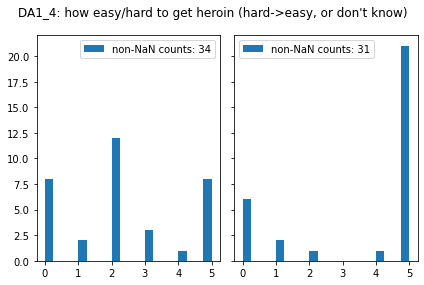

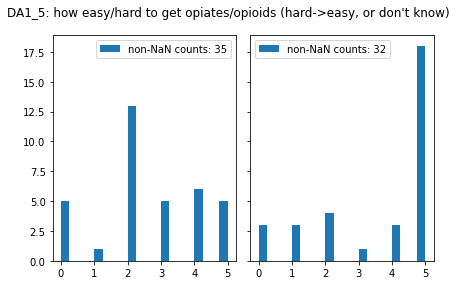

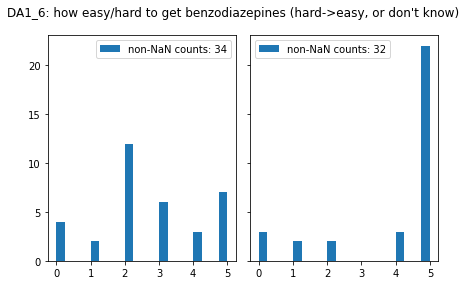

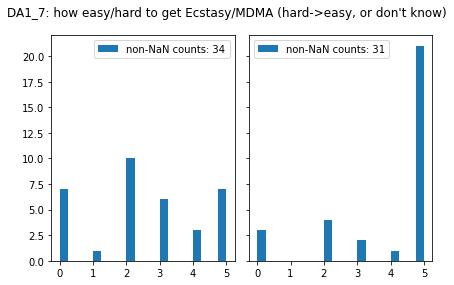

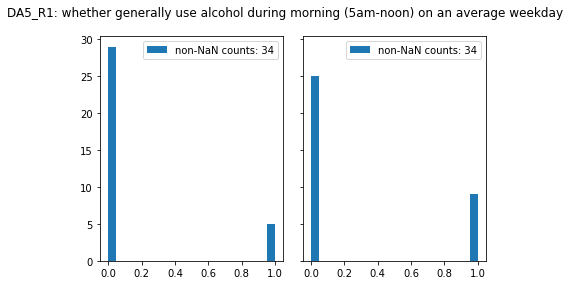

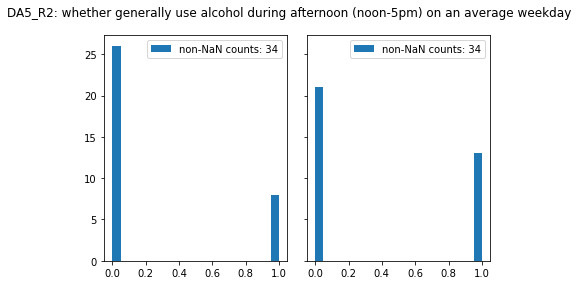

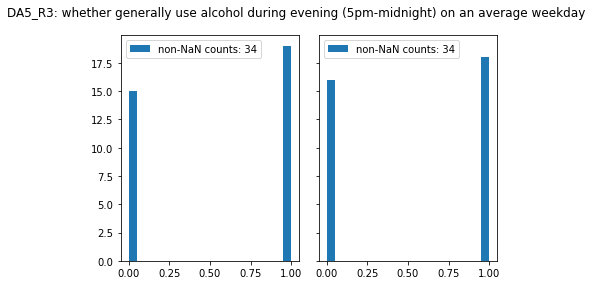

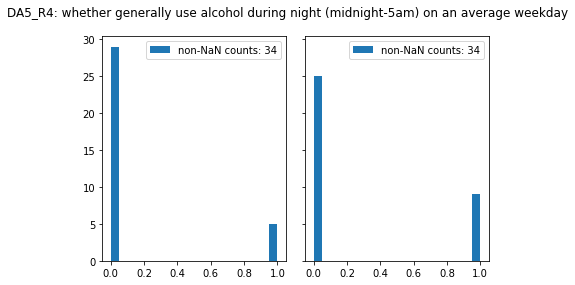

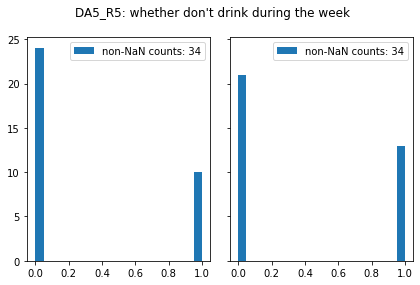

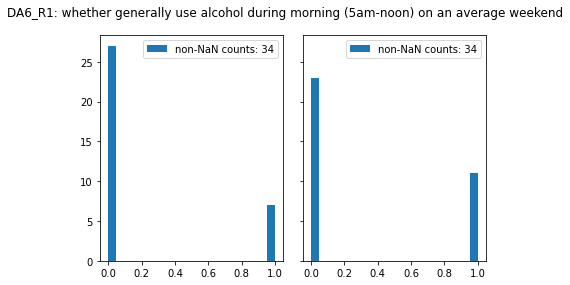

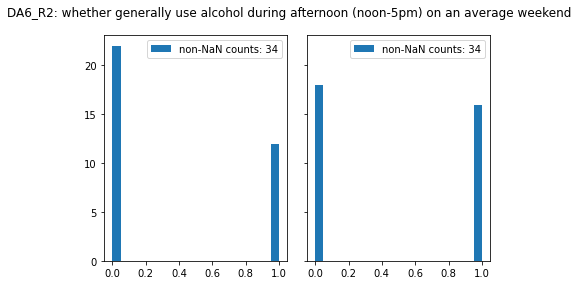

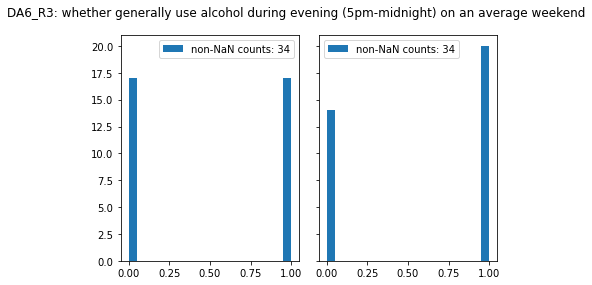

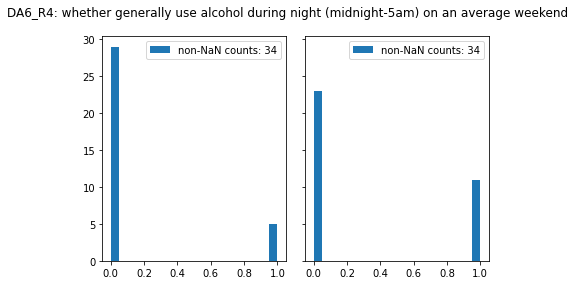

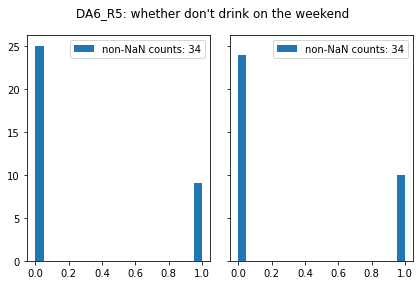

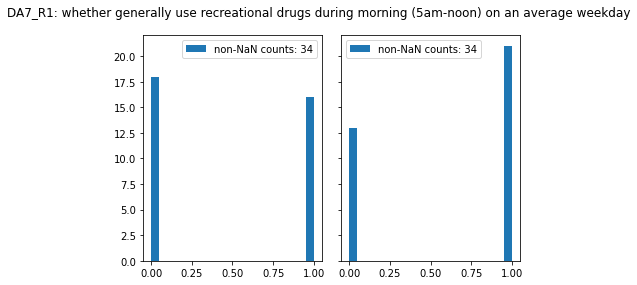

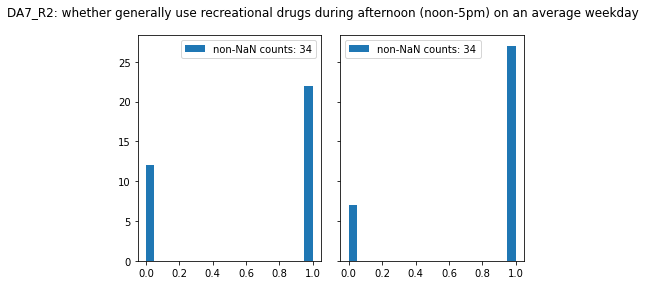

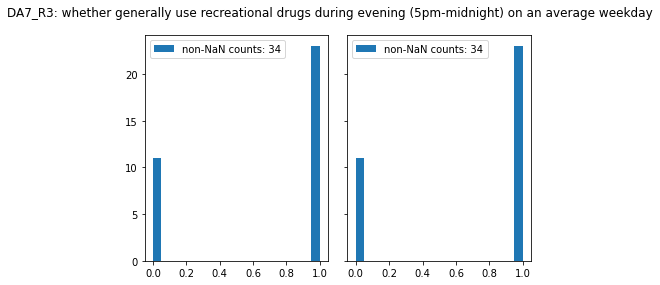

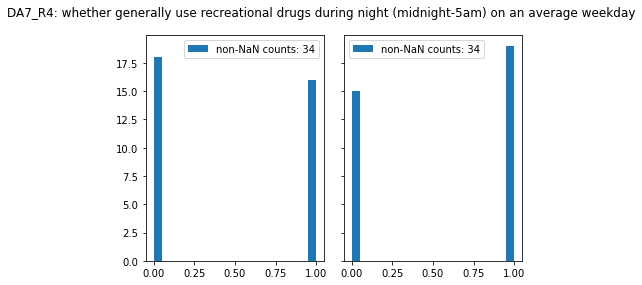

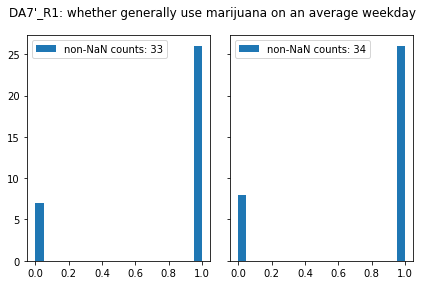

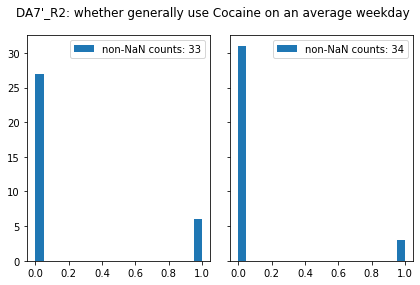

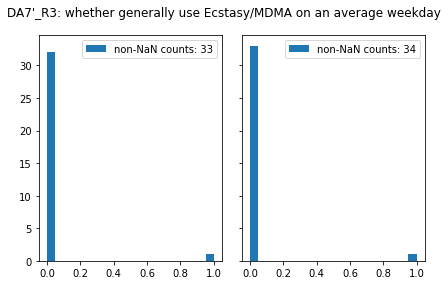

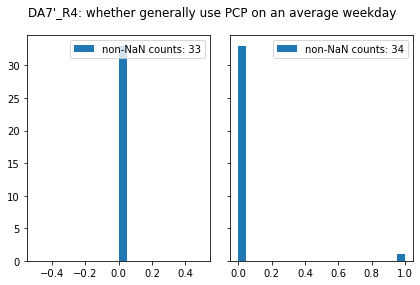

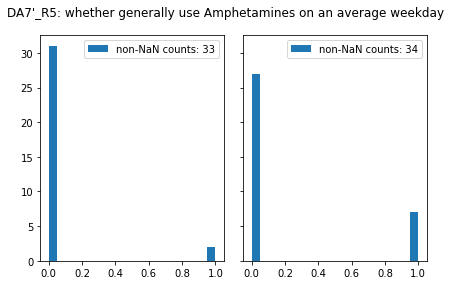

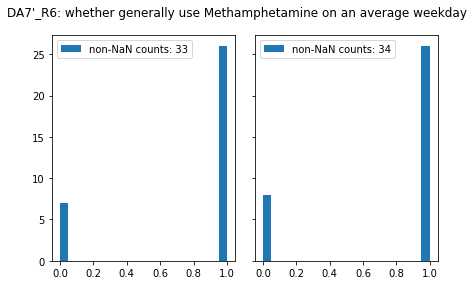

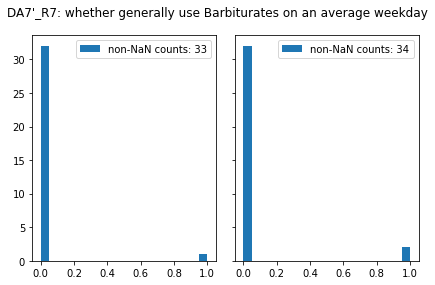

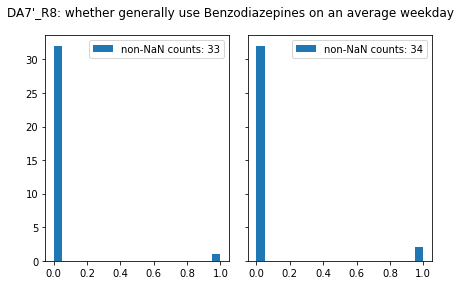

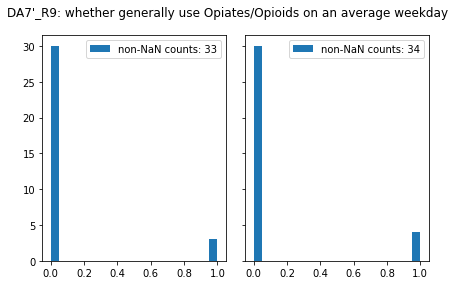

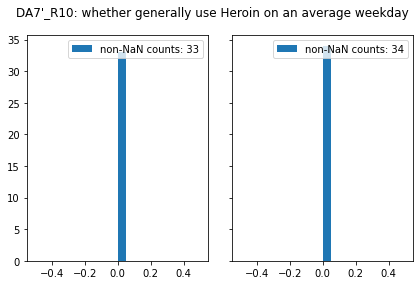

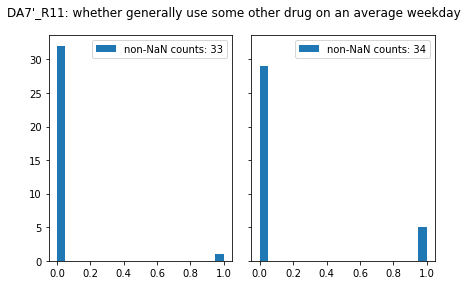

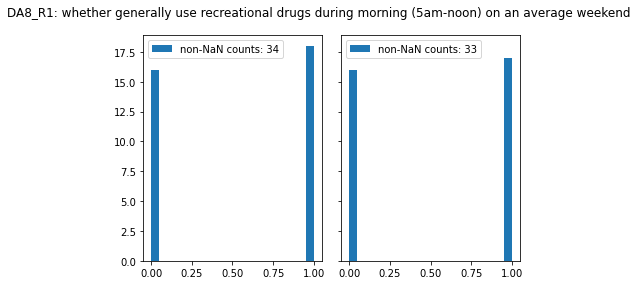

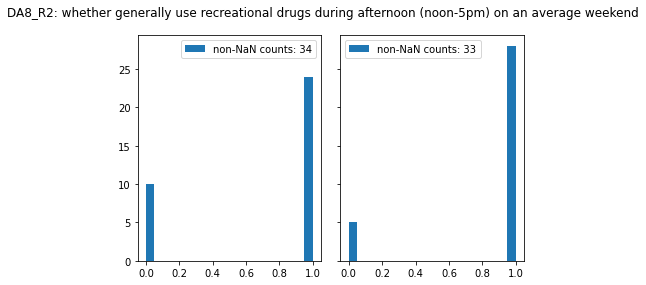

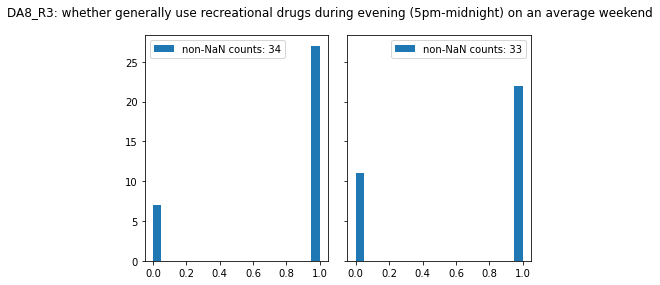

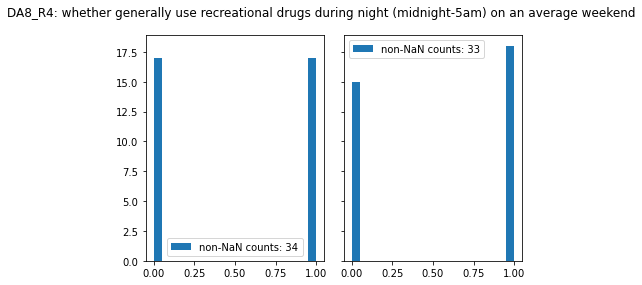

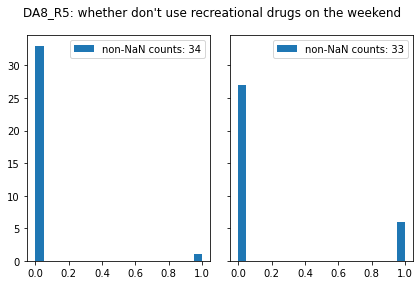

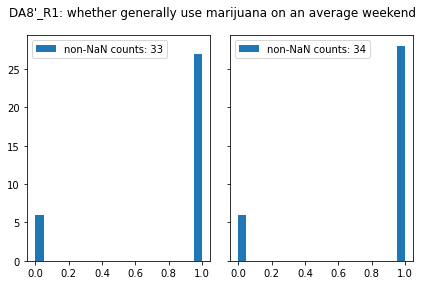

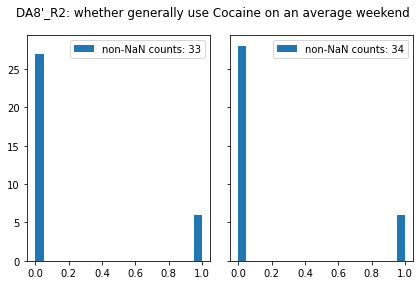

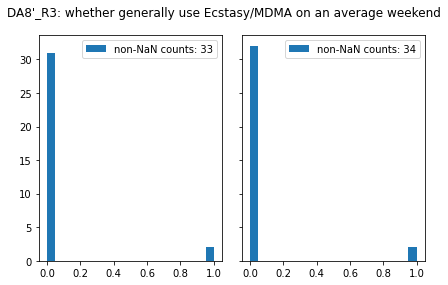

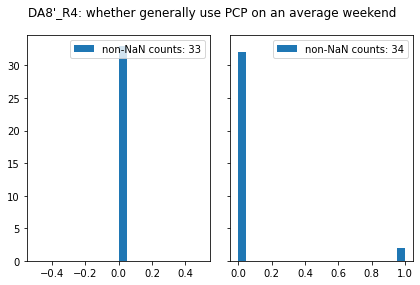

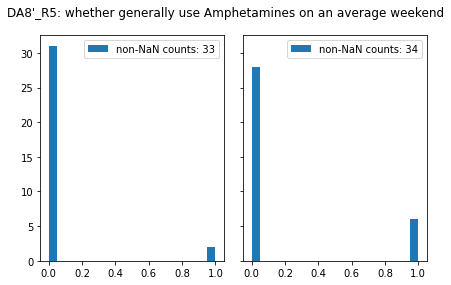

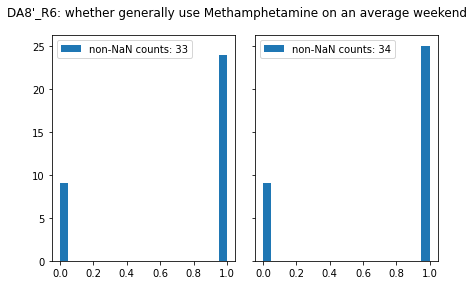

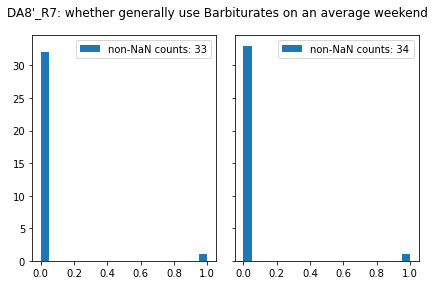

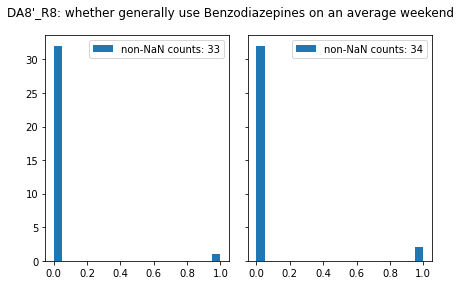

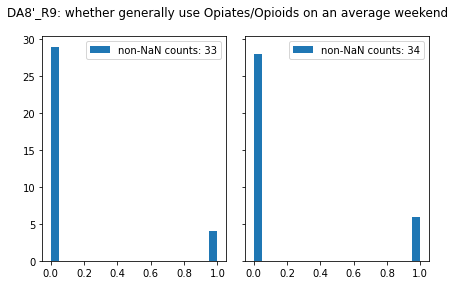

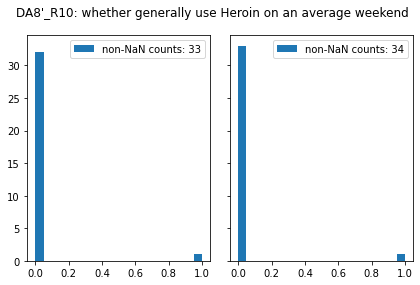

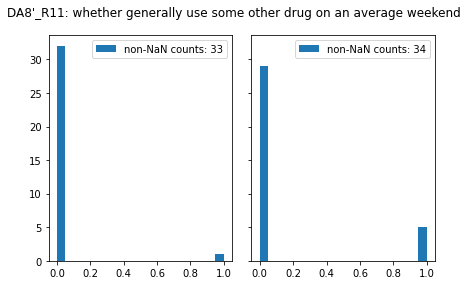

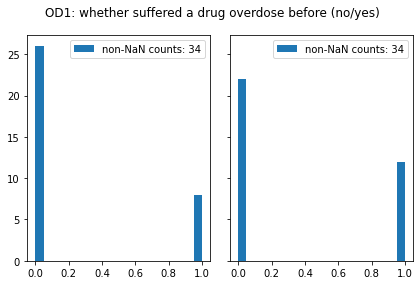

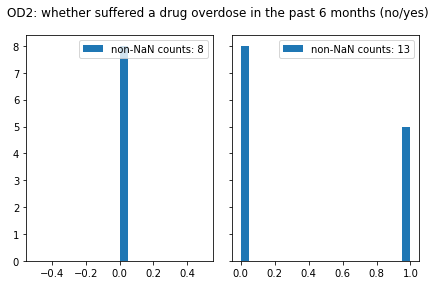

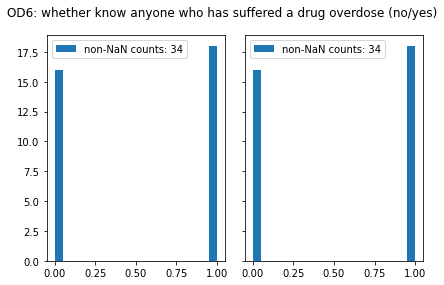

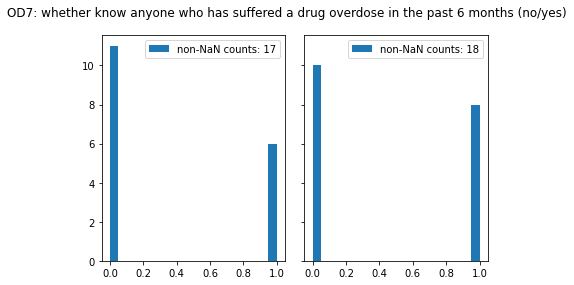

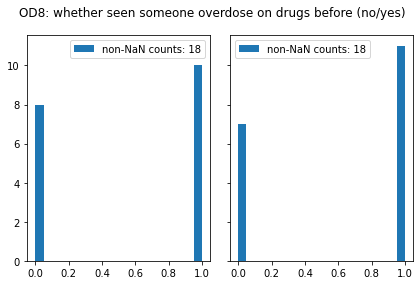

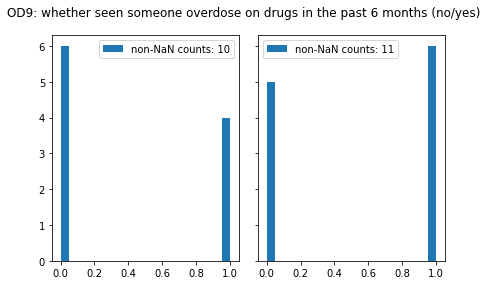

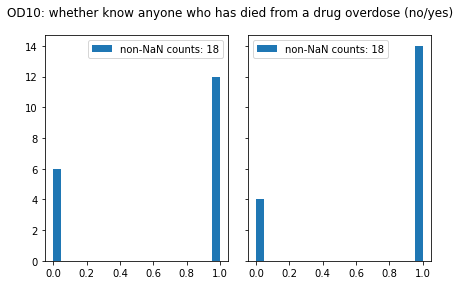

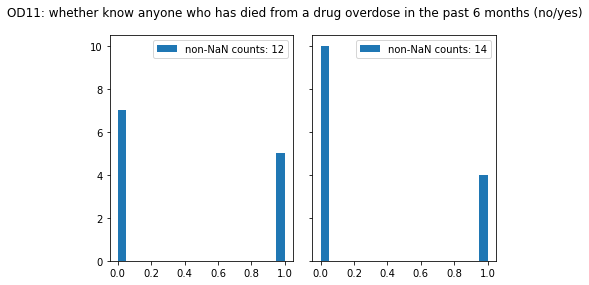

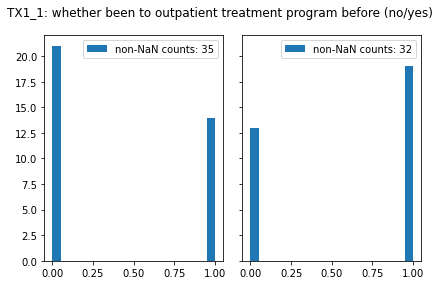

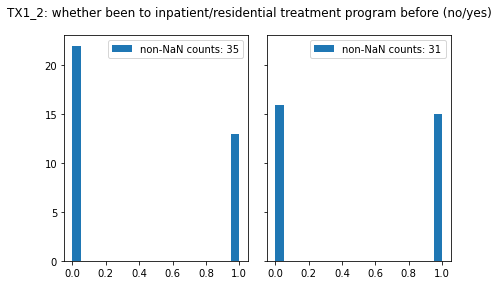

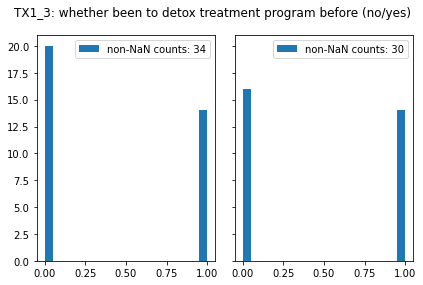

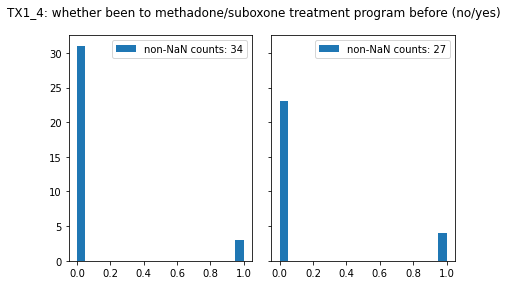

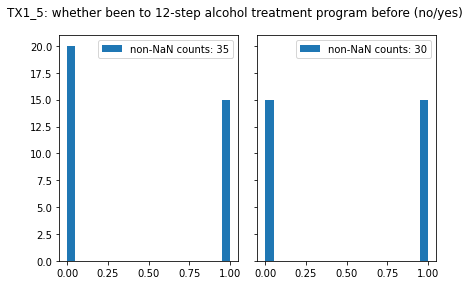

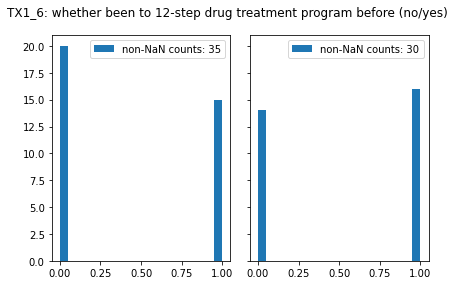

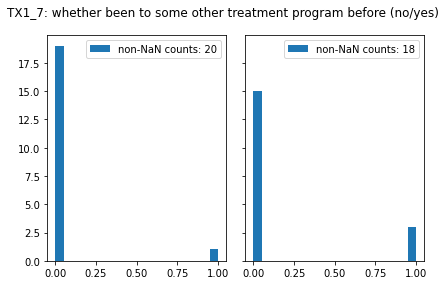

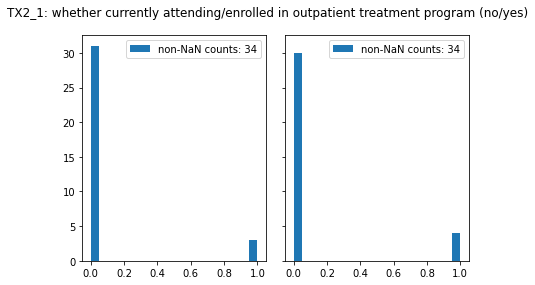

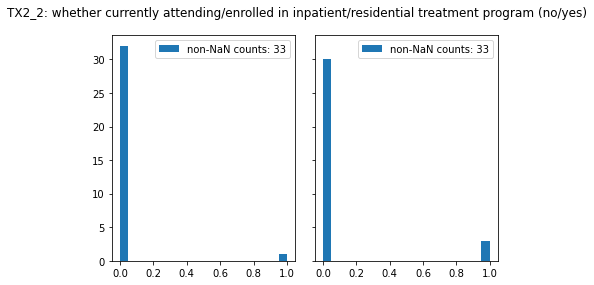

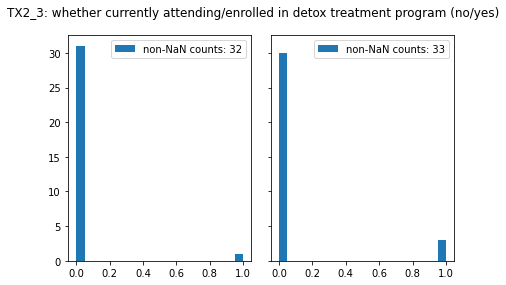

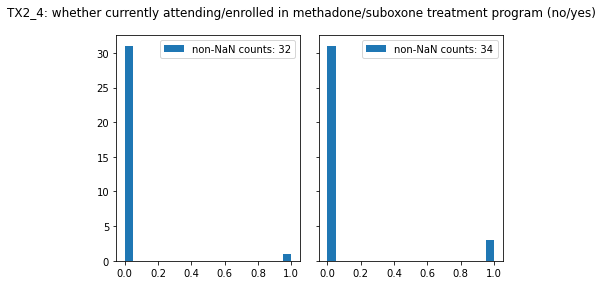

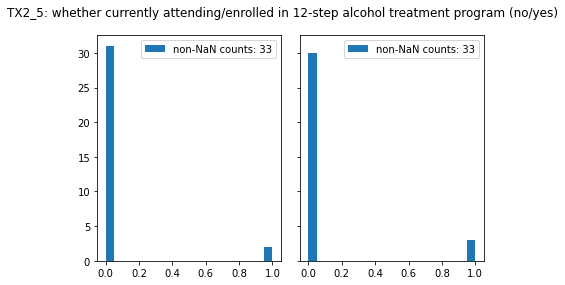

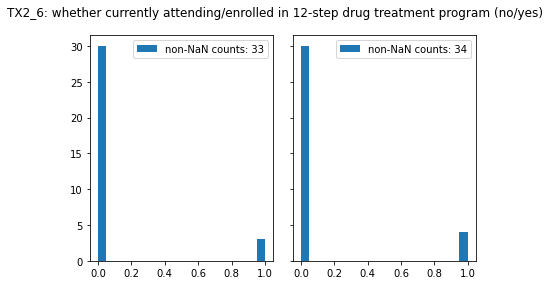

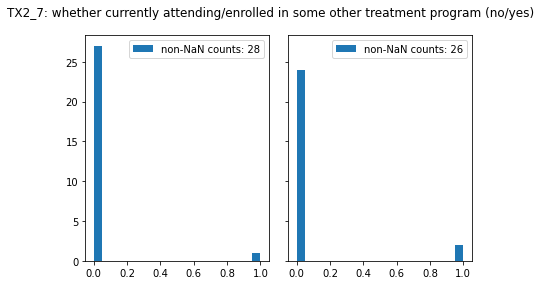

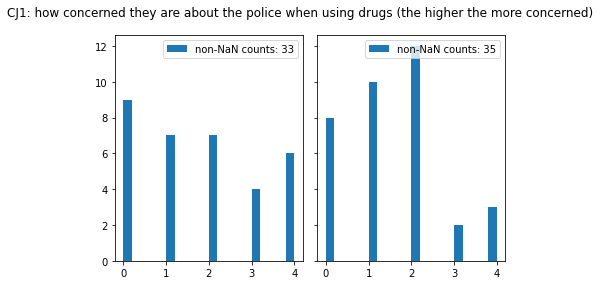

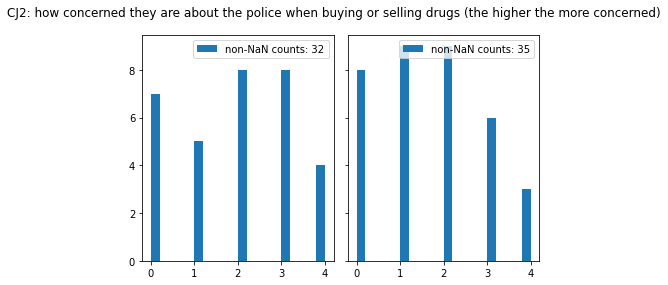

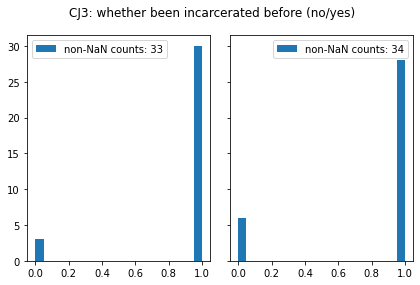

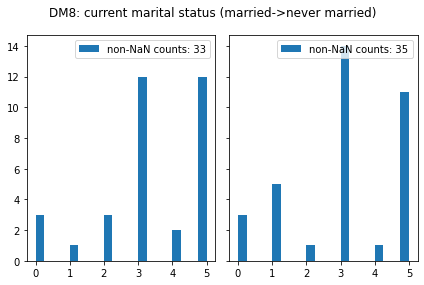

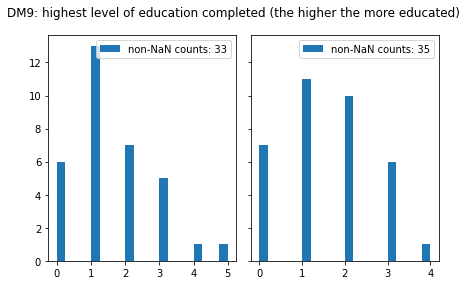

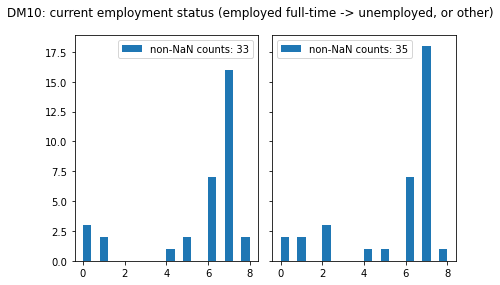

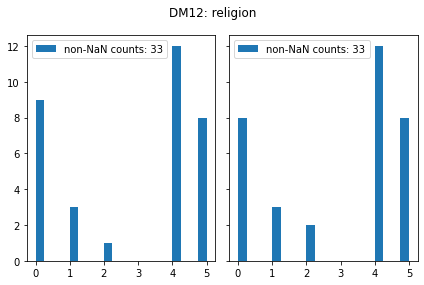

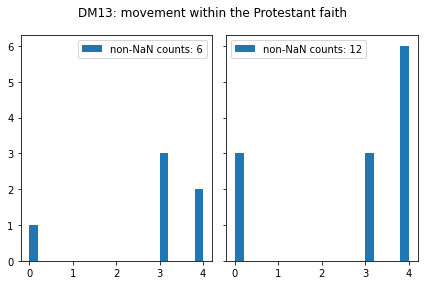

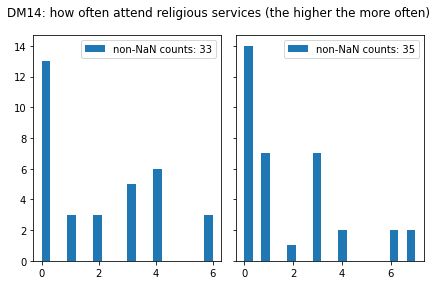

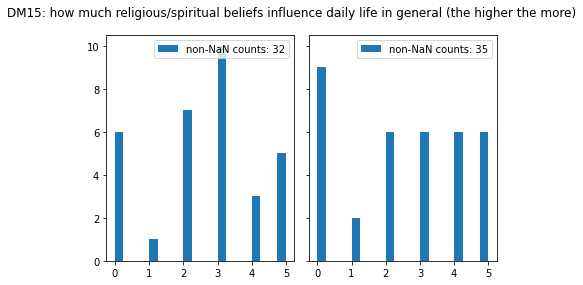

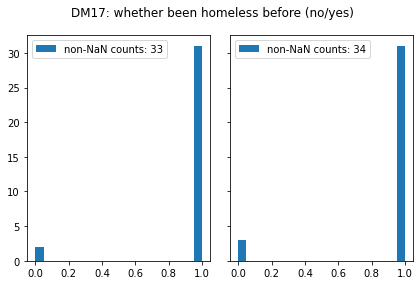

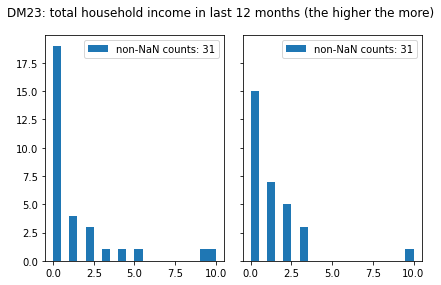

In [11]:
for key in mappings.keys():
    val = mappings[key]
    a = df_C1W1nonet.iloc[:,val[2]]
    b = df_C1W2nonet.iloc[:,val[3]]
    if key[-1] != '^':  # exclude text variables
        leg1, leg2 = 'non-NaN counts: ' + str(np.sum(~np.isnan(a))), 'non-NaN counts: ' + str(np.sum(~np.isnan(b)))
        fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
        plt.suptitle(re.sub('[^A-Za-z0-9]+$', '', key) + ': ' + val[1])
        axs[0].hist(a,bins=20)
        axs[0].legend([leg1])
        axs[1].hist(b,bins=20)
        axs[1].legend([leg2])

Some corner cases:
- Variables exclusive to W1:
    - All AC (adverse childhood) variables
    - CJ4: whether been incarcerated in the past 12 months (no/yes)
    - CJ5: length of longest incarceration (the higher the more time)
    - CJ6: whether any of incarcerations been drug related (no/yes)
    - CJ7: whether received any drug treatment while incarcerated before (no/yes)

/tmp/ipykernel_2115/4195331434.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


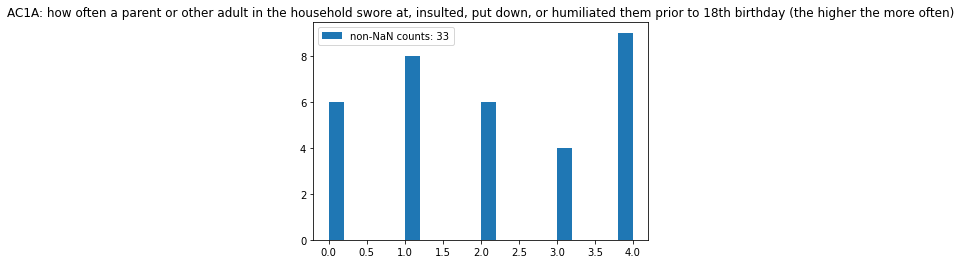

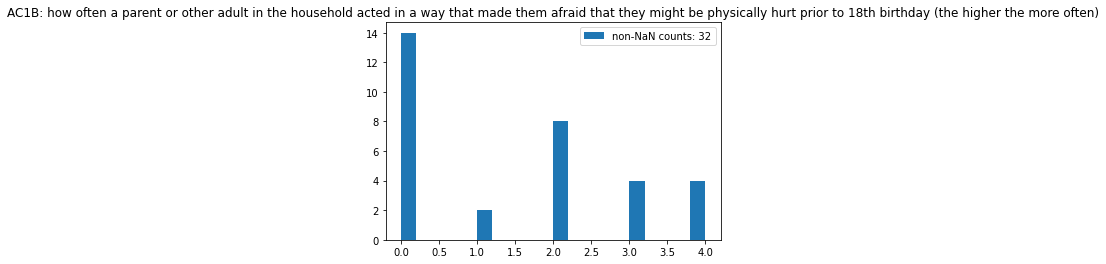

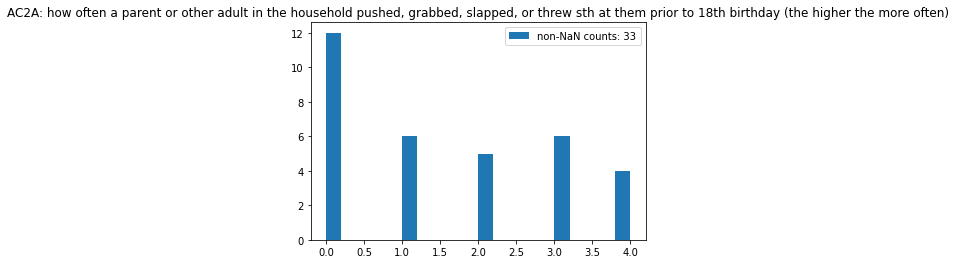

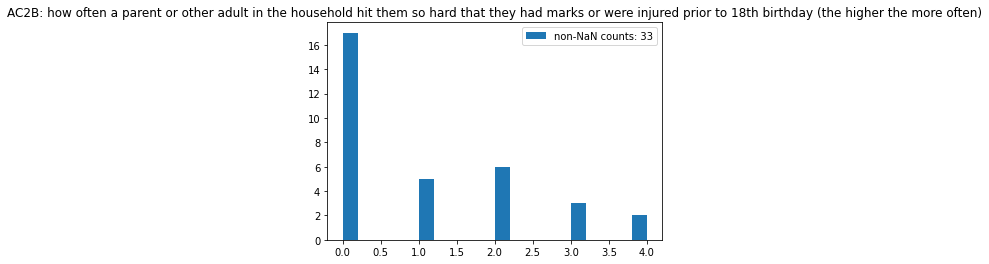

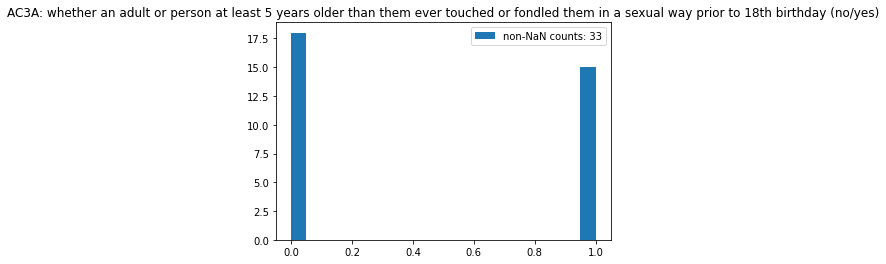

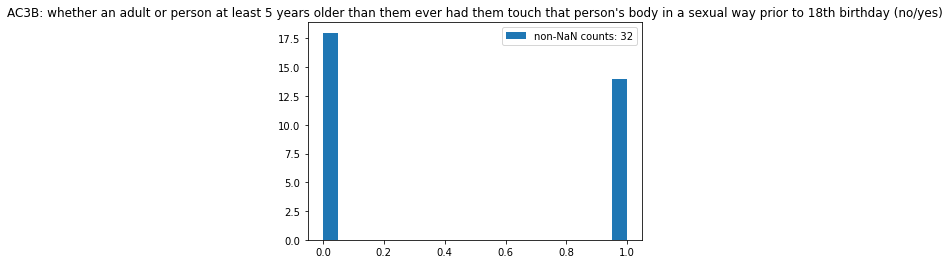

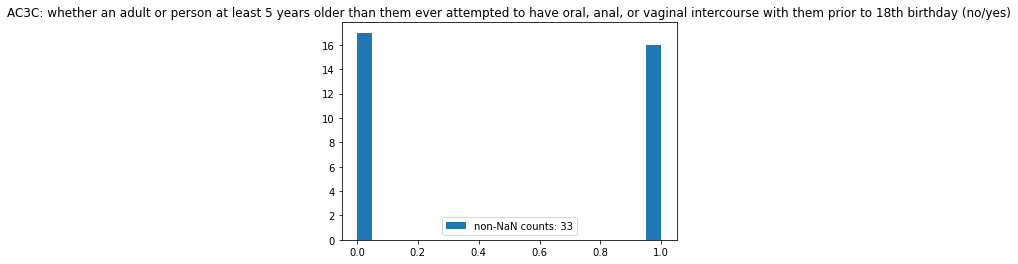

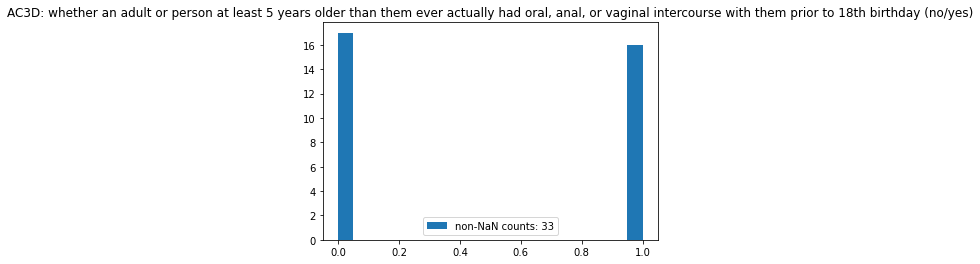

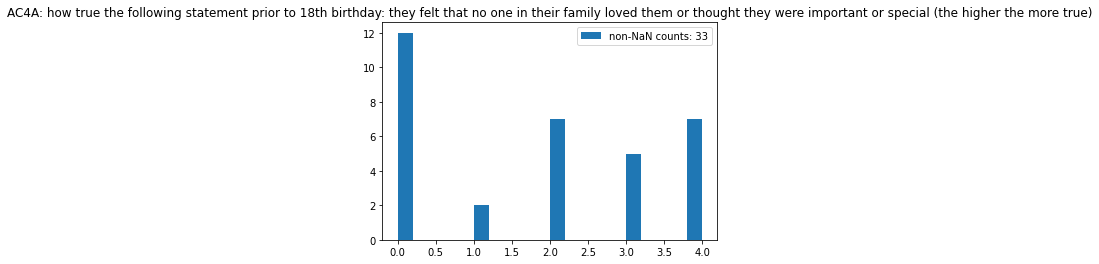

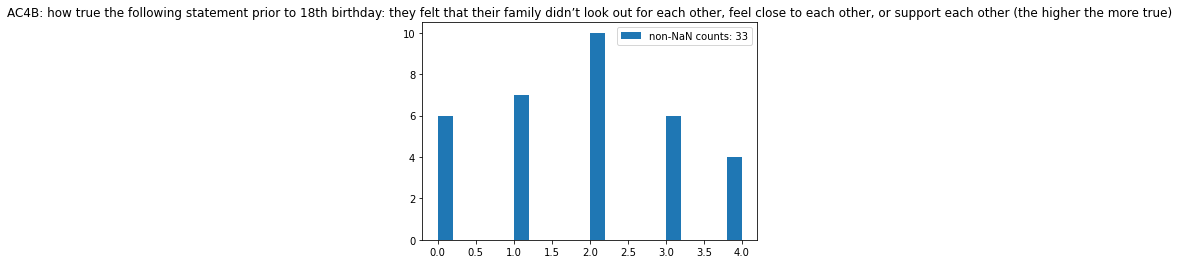

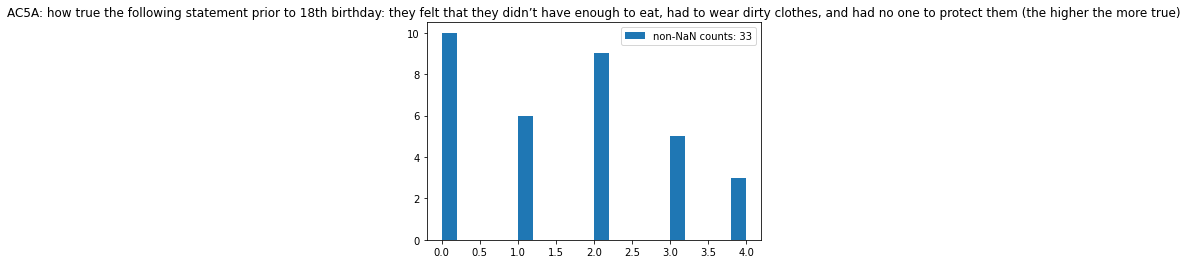

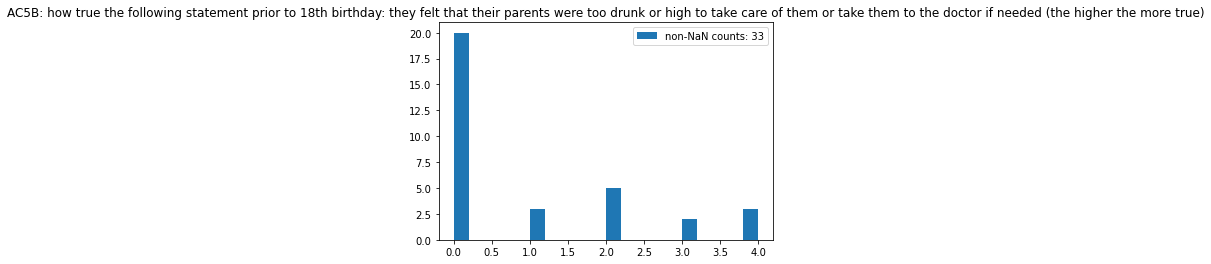

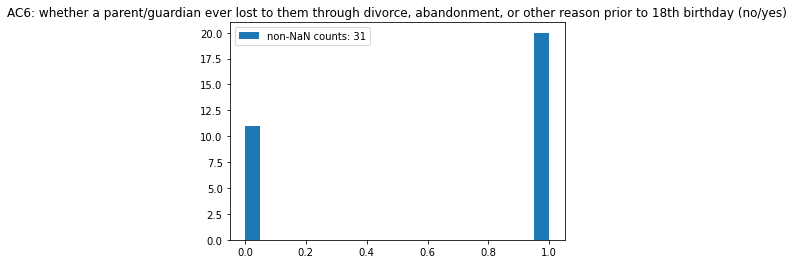

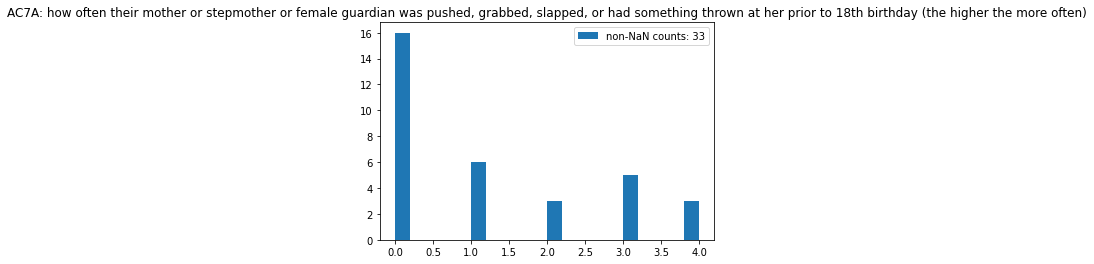

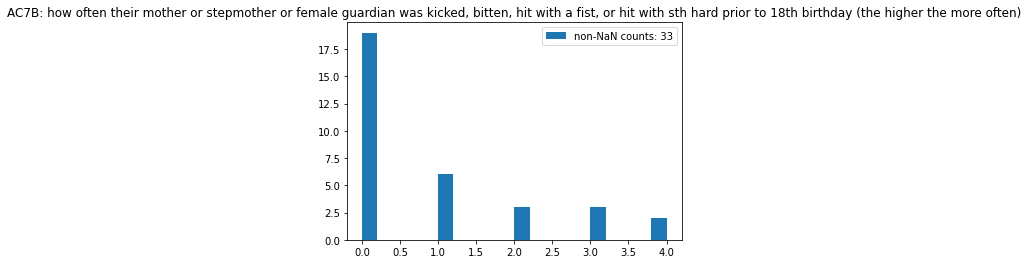

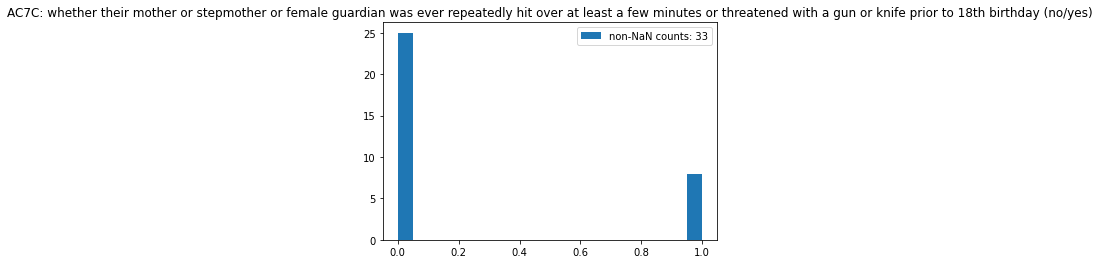

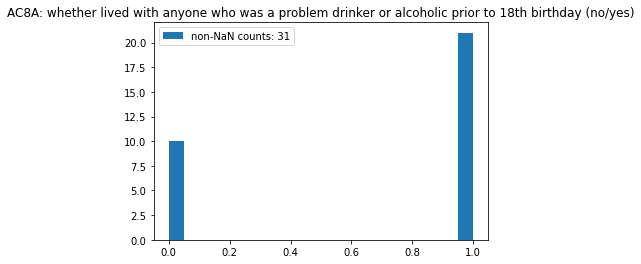

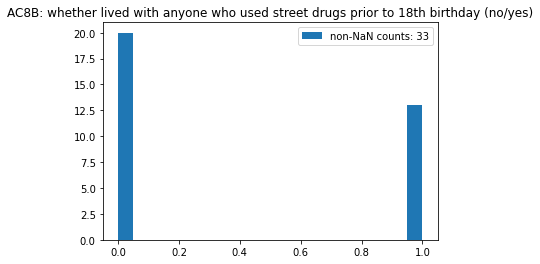

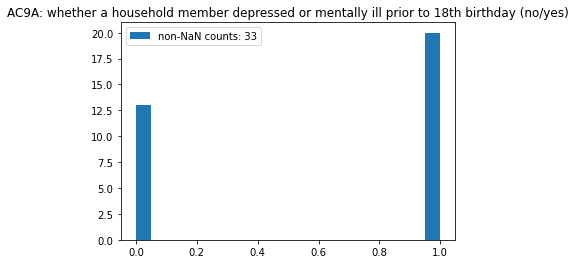

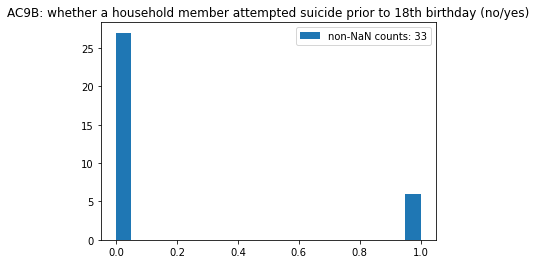

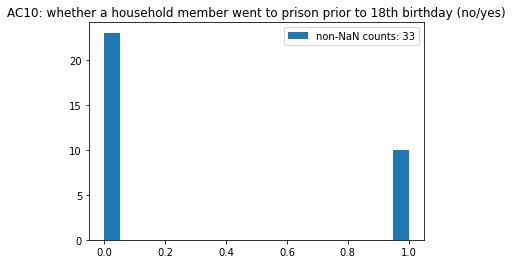

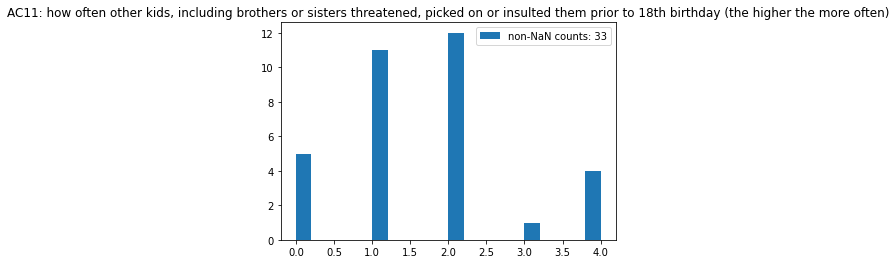

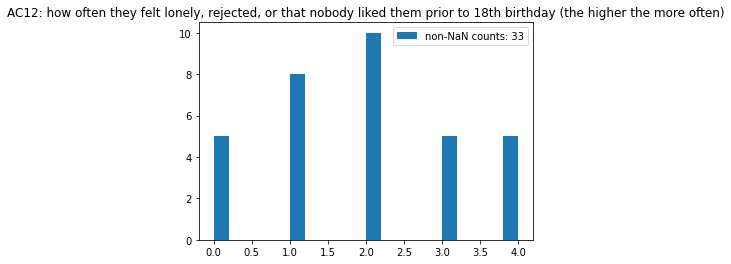

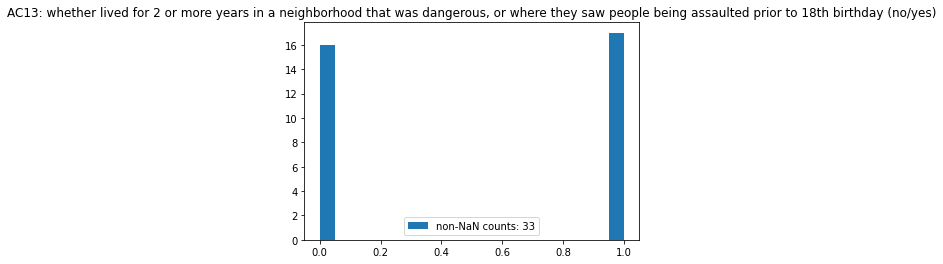

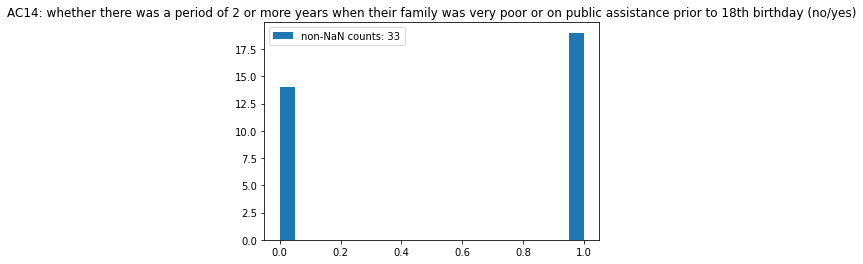

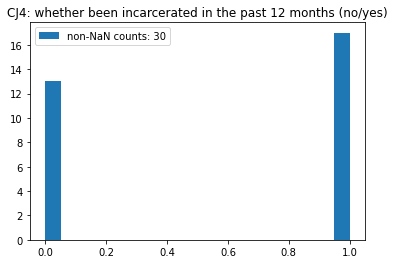

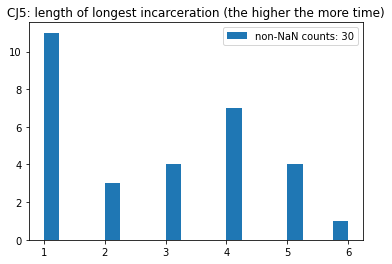

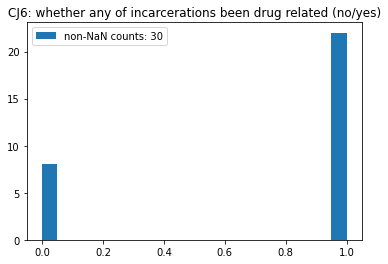

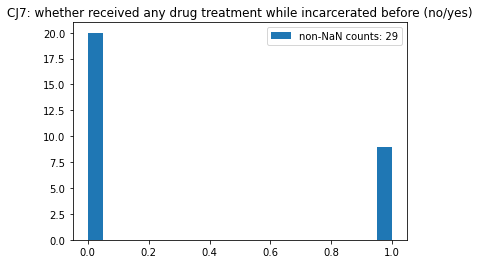

In [12]:
W1_exckeys = [col for col in df_C1W1nonet if col.startswith('AC')]
W1_exckeys.extend(['CJ4','CJ5','CJ6','CJ7'])
for key in W1_exckeys:
    a = df_C1W1nonet[key]
    leg = 'non-NaN counts: ' + str(np.sum(~np.isnan(a)))
    fig, ax = plt.subplots()
    ax.set_title(key + ': ' + dict1[key])
    ax.hist(a,bins=20)
    ax.legend([leg])

- Variables exclusive to W2:
    - Q70: how old regularly used marijuana
    - Q199: whether been incarcerated in the past 6 months
    - Q208_R4: other branch not listed within the Protestant faith (text)

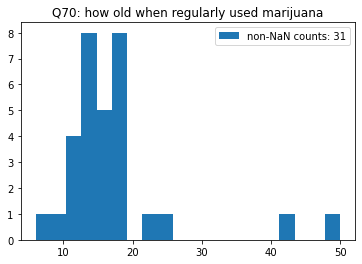

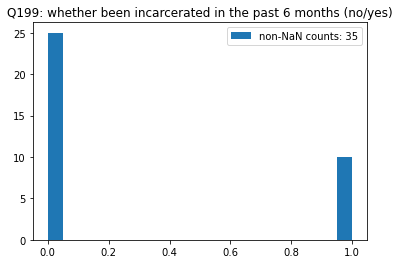

In [13]:
W2_exckeys = ['Q70','Q199']
for key in W2_exckeys:
    b = df_C1W2nonet[key]
    leg = 'non-NaN counts: ' + str(np.sum(~np.isnan(b)))
    fig, ax = plt.subplots()
    ax.set_title(key + ': ' + dict2[key])
    ax.hist(b,bins=20)
    ax.legend([leg])

Text variables:
- ID13-Q50: other drug injected in the past 6 months
- ID14-Q51: kind of places/locations typically injected drugs in
- ND13-Q81: other non-injection substance used in the past 6 months
- ND15-Q84: kind of places/locations typically used non-injection drugs in
- DM12_6_TEXT-Q207_R5: religion other than listed
- Q208_R4: other branch not listed within the Protestant faith